In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=462ef6cba3d8a48a56c00267cbf814914bd4ae2615e6d729a0e099db95ade848
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("YourApp").getOrCreate()

# Read the CSV file into a Spark DataFrame
df = spark.read.csv("/content/drive/MyDrive/bid_data_project/joint.csv", header=True, inferSchema=True)

In [21]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from google.colab import files


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

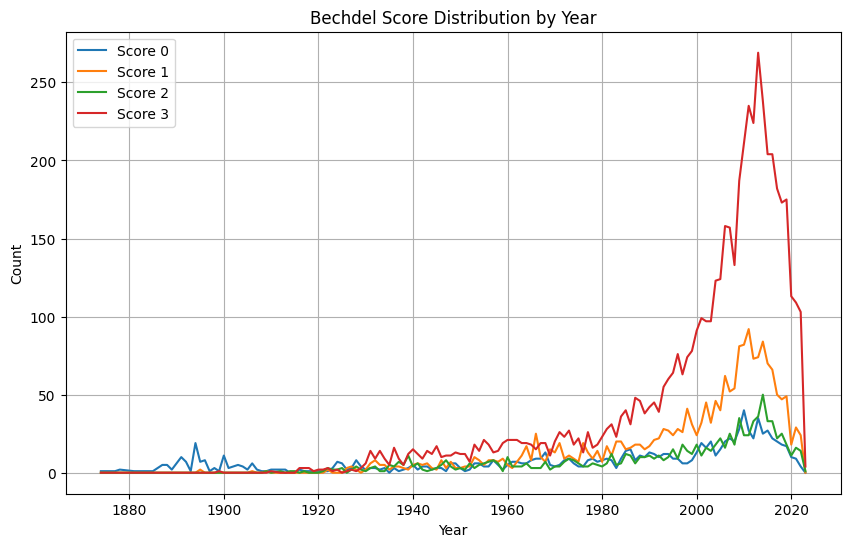

In [24]:
grouped_scores = df.groupBy("year", "Bechdel Score").count().orderBy("year")

# Pivot the data to have each Bechdel score as a separate column
pivoted = grouped_scores.groupBy("year").pivot("Bechdel Score").agg(F.sum("count").alias("count")).fillna(0).orderBy("year")

# Convert to Pandas DataFrame for plotting
pandas_df = pivoted.toPandas()

# Plot distribution curves for each Bechdel Score
plt.figure(figsize=(10, 6))
for score in range(4):  # possible bechdel 0,1,2,3
    plt.plot(pandas_df['year'], pandas_df[str(score)], label=f"Score {score}")

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Bechdel Score Distribution by Year')
plt.legend()
plt.grid(True)
plt.savefig("Bechdel Score Distribution by Year.png")
files.download("Bechdel Score Distribution by Year.png")
plt.show()

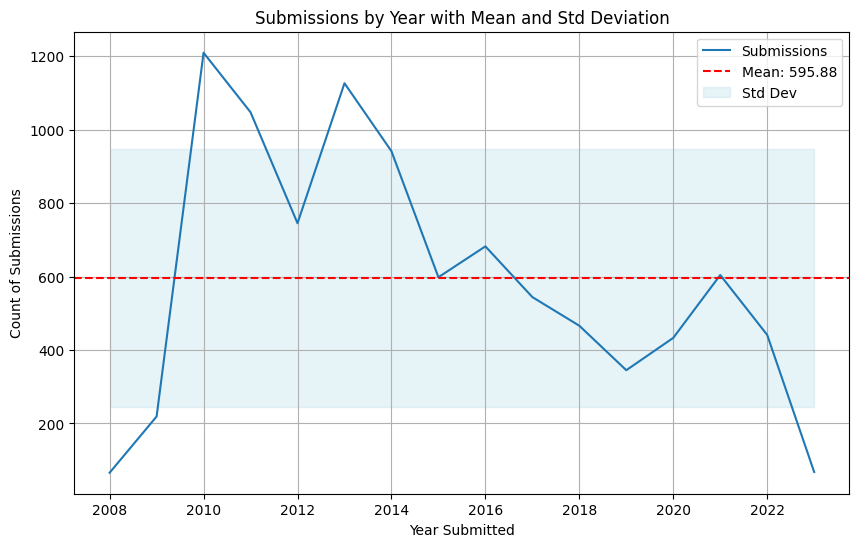

In [26]:
import numpy as np

subdist = df.groupBy("year submitted").count().orderBy("year submitted")

pandas_df = subdist.toPandas()

# Calculate mean and standard deviation
mean = pandas_df['count'].mean()
std_dev = pandas_df['count'].std()

# Plot count of submissions by year submitted
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['year submitted'], pandas_df['count'], label='Submissions')

# Plot mean line
plt.axhline(y=mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')

# Plot std deviation range
plt.fill_between(pandas_df['year submitted'], mean - std_dev, mean + std_dev, color='lightblue', alpha=0.3, label='Std Dev')

plt.xlabel('Year Submitted')
plt.ylabel('Count of Submissions')
plt.title('Submissions by Year with Mean and Std Deviation')
plt.legend()
plt.grid(True)
plt.show()


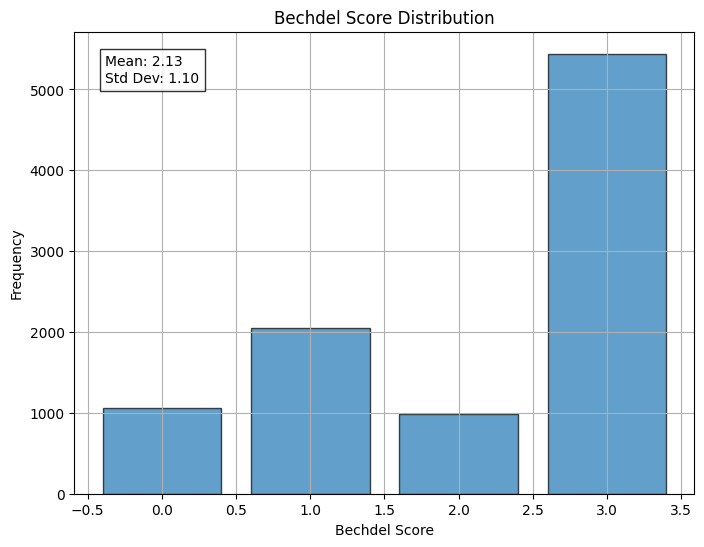

In [29]:
# bechdel stats

mean, std_dev = df.agg(F.mean("Bechdel Score"), F.stddev("Bechdel Score")).first()

# Plot histogram of Bechdel scores
plt.figure(figsize=(8, 6))
plt.hist(df.select("Bechdel Score").rdd.flatMap(lambda x: x).collect(), bins=np.arange(5), align='left', rwidth=0.8, edgecolor='black', alpha=0.7)
plt.xlabel('Bechdel Score')
plt.ylabel('Frequency')
plt.title('Bechdel Score Distribution')

# Display mean and standard deviation as text
plt.text(0.05, 0.95, f'Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

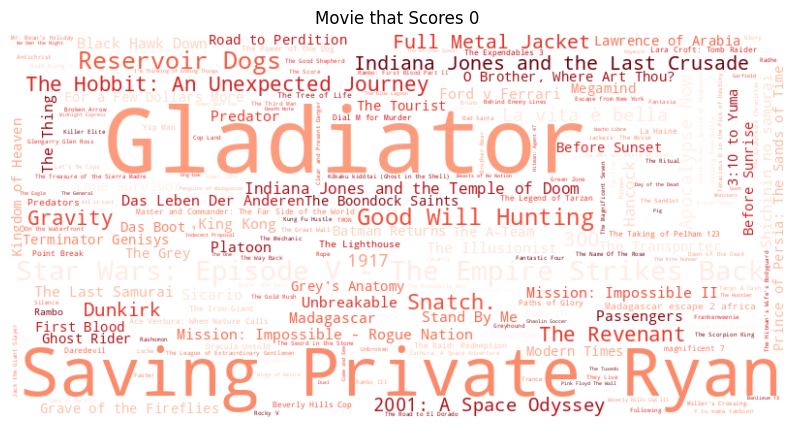

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

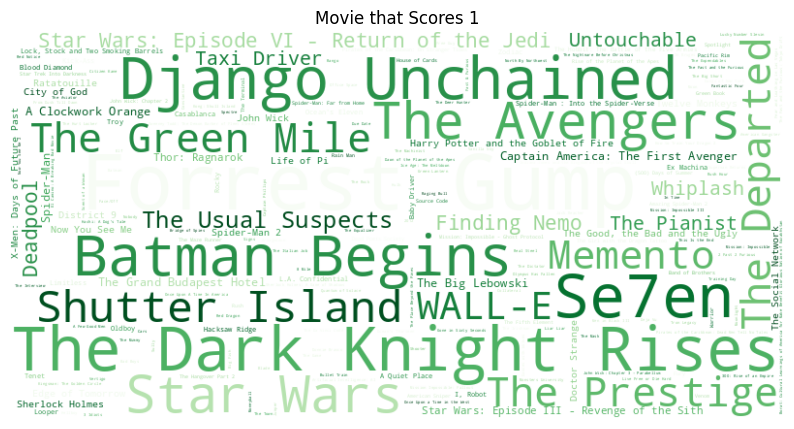

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

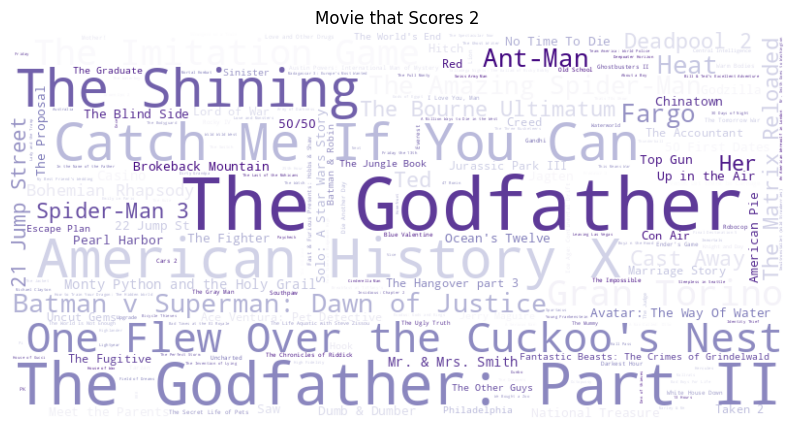

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

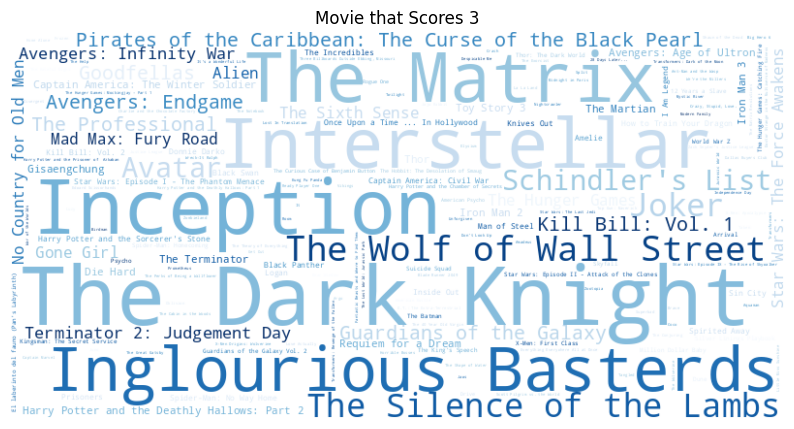

In [52]:
import html
from wordcloud import WordCloud
from pyspark.sql import functions as F

def transform_title(title):
    if title.endswith(', The'):
        return 'The ' + title[:-5]
    elif title.endswith(', A'):
        return 'A ' + title[:-4]
    elif title.endswith(', An'):
        return 'An ' + title[:-5]
    else:
        return title

def decode_html_entities(title):
    return html.unescape(title)


transformed_df = df.withColumn('TransformedTitle', F.udf(transform_title)(F.col('Title')))
decoded_df = transformed_df.withColumn('DecodedTitle', F.udf(decode_html_entities)(F.col('TransformedTitle')))


color_map = ['Reds','Greens','Purples','Blues']


for score in range(4):

    filtered_score_df = decoded_df.filter(decoded_df['Bechdel Score'] == score)


    titles_votes = {row['DecodedTitle']: row['imdbVotes'] for row in filtered_score_df.select('DecodedTitle', 'imdbVotes').collect()}

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color_map[score])

    wordcloud.generate_from_frequencies(titles_votes)


    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Movie that Scores {score}')
    plt.savefig(f'Movie that Scores {score}.png')
    files.download(f'Movie that Scores {score}.png')
    plt.show()


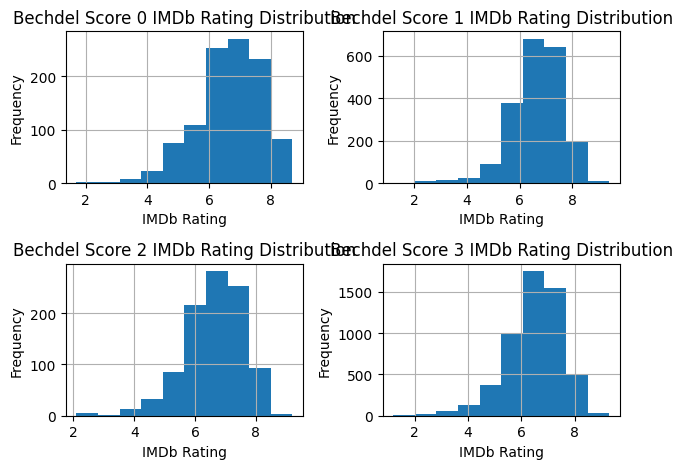

In [6]:
spark = SparkSession.builder.appName("IMDbRatingDistribution").getOrCreate()
df = df.withColumn("imdbRating", df["imdbRating"].cast("float"))

# Group by Bechdel score and compute IMDb rating statistics
grouped_data = df.groupBy("Bechdel Score").agg({"imdbRating": "collect_list"})

# Convert Spark DataFrame to Pandas for visualization
grouped_pd = grouped_data.toPandas()

for i, score in enumerate(range(4)):
    plt.subplot(2, 2, i+1)
    plt.hist(grouped_pd.loc[grouped_pd['Bechdel Score'] == score]['collect_list(imdbRating)'].values[0], bins=10)
    plt.title(f"Bechdel Score {score} IMDb Rating Distribution")
    plt.xlabel("IMDb Rating")
    plt.ylabel("Frequency")
    plt.grid(True)

plt.tight_layout()
plt.show()




In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

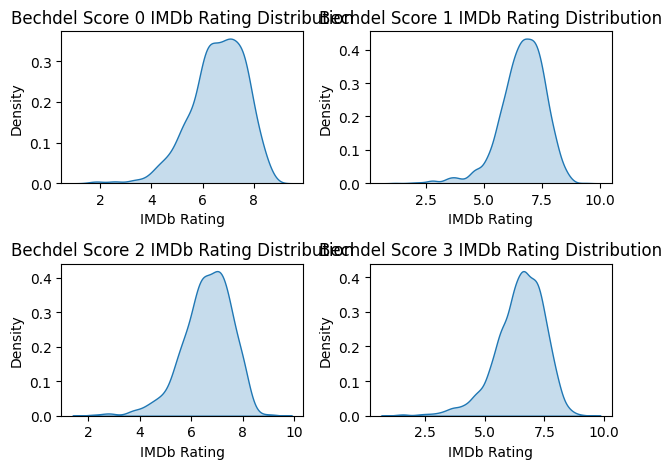

In [17]:
for i, score in enumerate(range(4)):
    plt.subplot(2, 2, i + 1)
    ratings = grouped_pd.loc[grouped_pd['Bechdel Score'] == score]['collect_list(imdbRating)'].values[0]
    sns.kdeplot(ratings, fill=True)
    plt.title(f"Bechdel Score {score} IMDb Rating Distribution")
    plt.xlabel("IMDb Rating")
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

In [23]:
unique_genres = set()

unique_genres = df.select("Genre").distinct().rdd.flatMap(lambda x: x[0].split(", ")).distinct().collect()

In [24]:
unique_genres

['Animation',
 'Comedy',
 'Fantasy',
 'Action',
 'Thriller',
 'Family',
 'Drama',
 'Crime',
 'Music',
 'Documentary',
 'Short',
 'Sport',
 'Adventure',
 'Sci-Fi',
 'Horror',
 'Musical',
 'History',
 'Adult',
 'Mystery',
 'Biography',
 'Romance',
 'War',
 'Western',
 'News',
 'Film-Noir',
 'Game-Show',
 'N/A']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

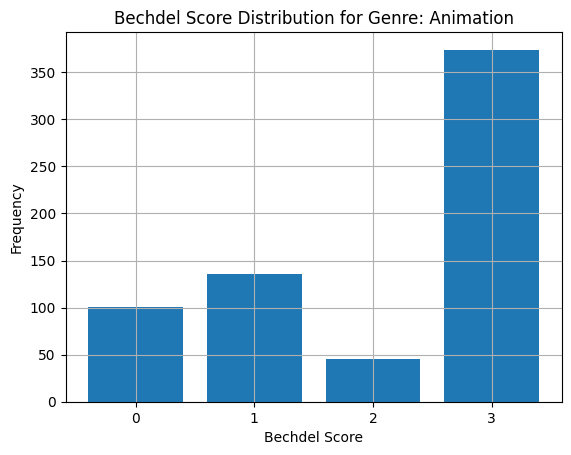

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

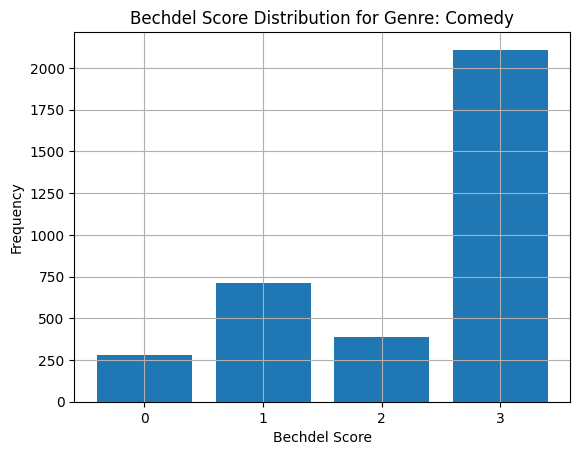

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

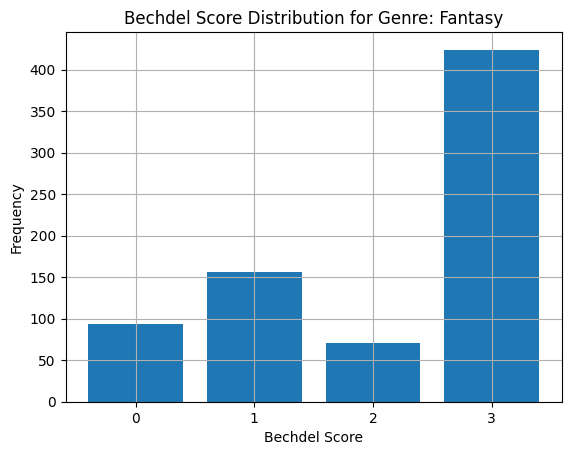

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

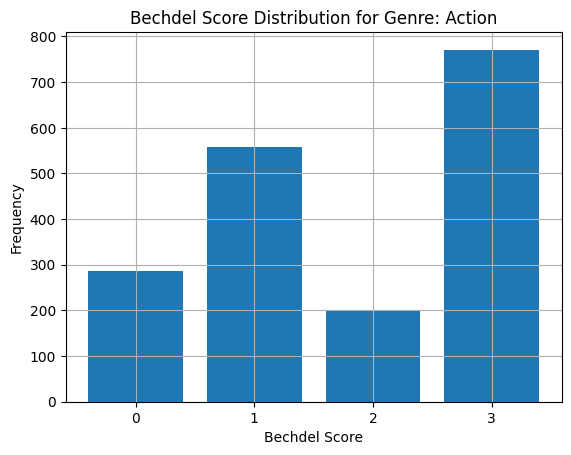

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

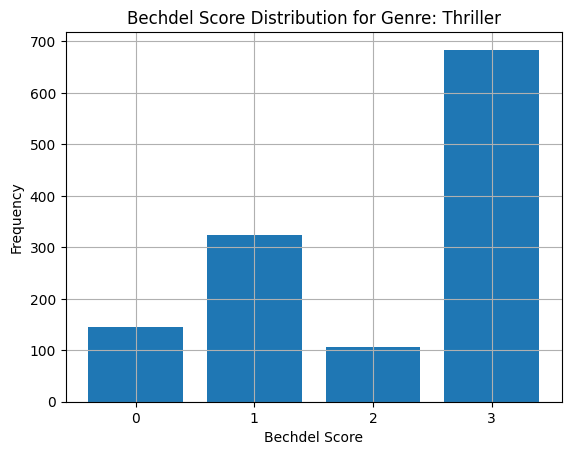

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

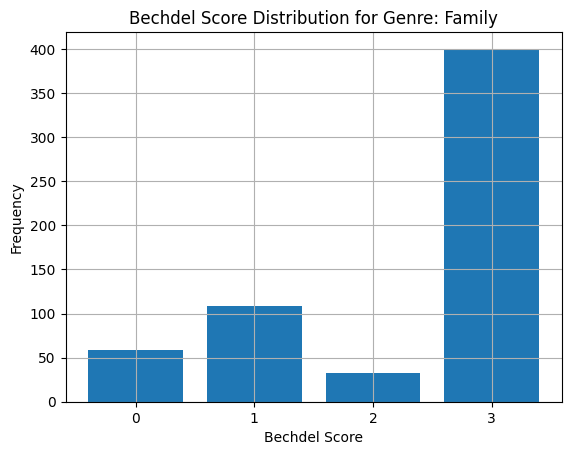

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

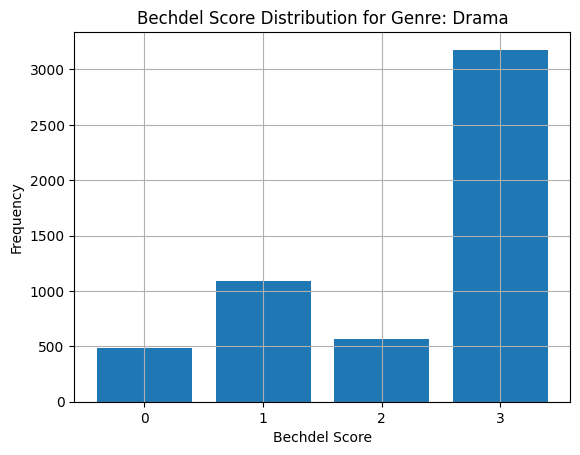

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

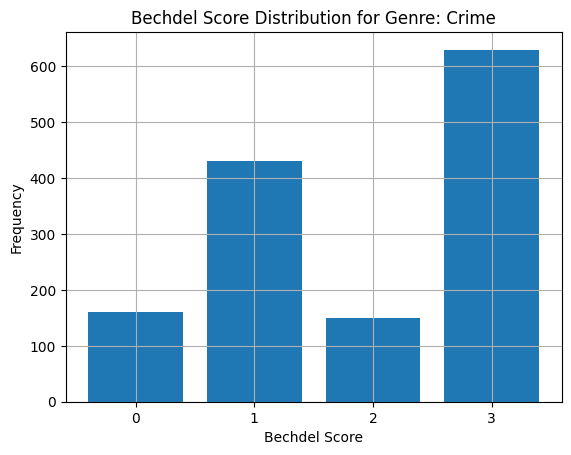

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

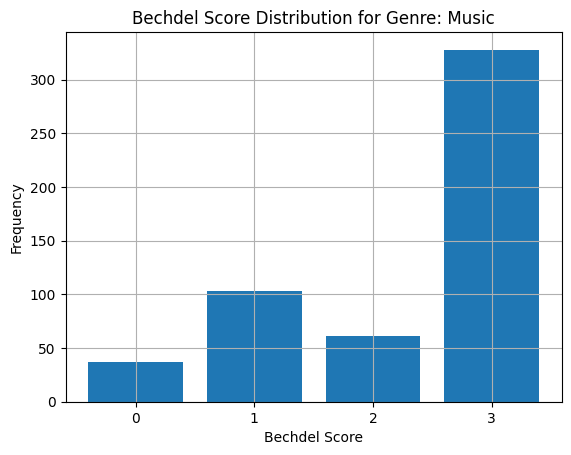

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

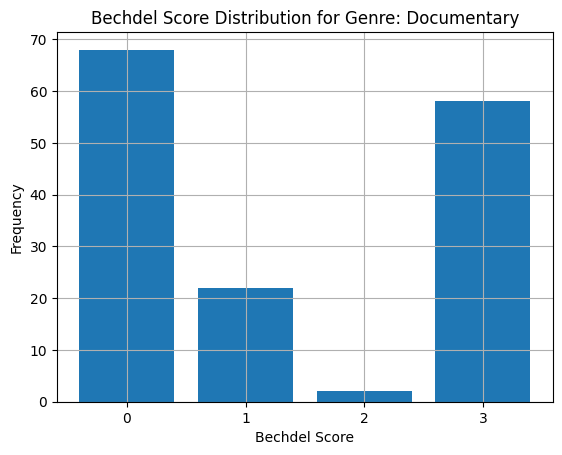

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

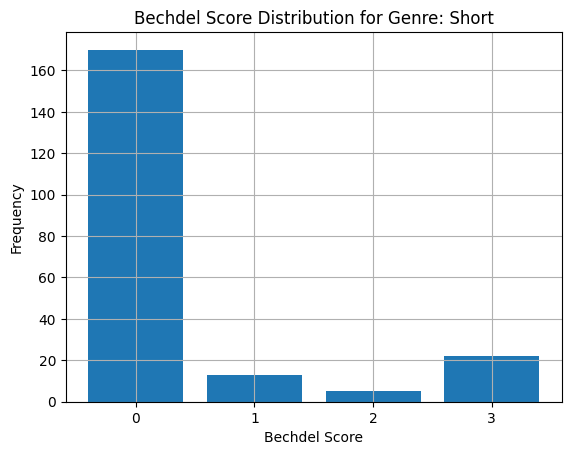

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

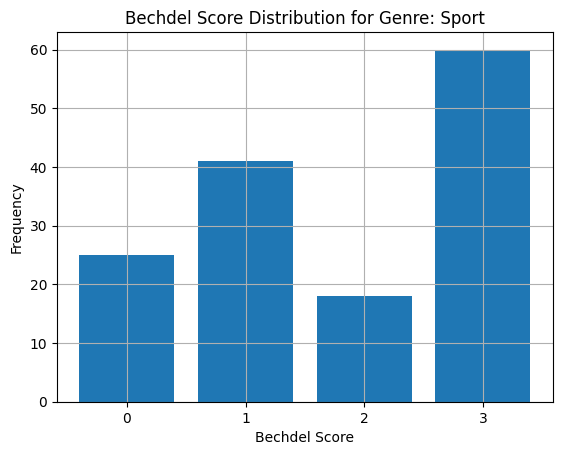

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

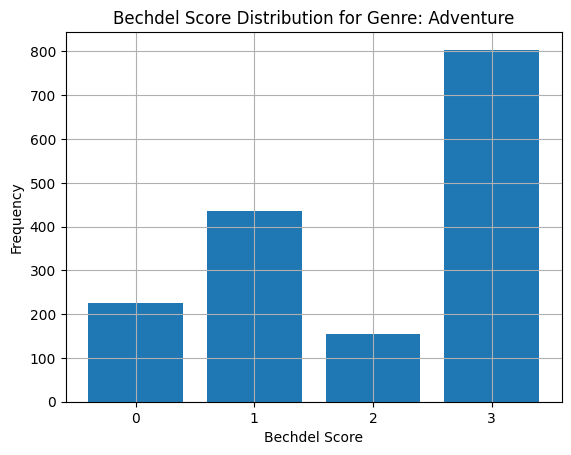

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

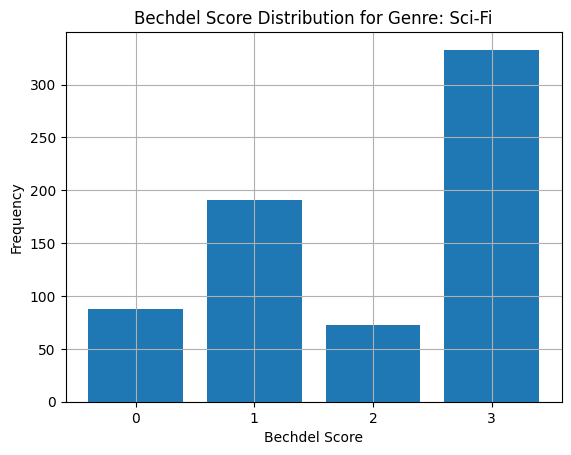

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

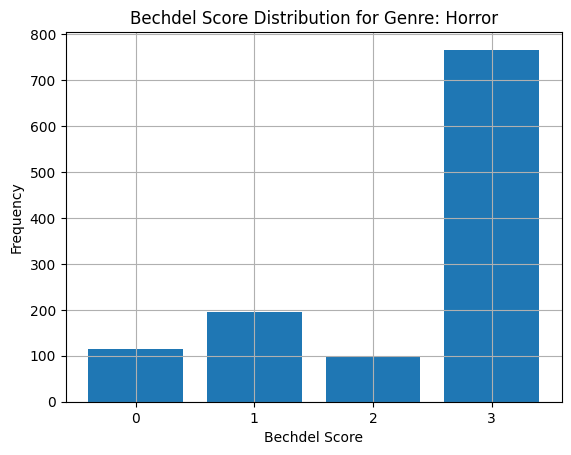

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

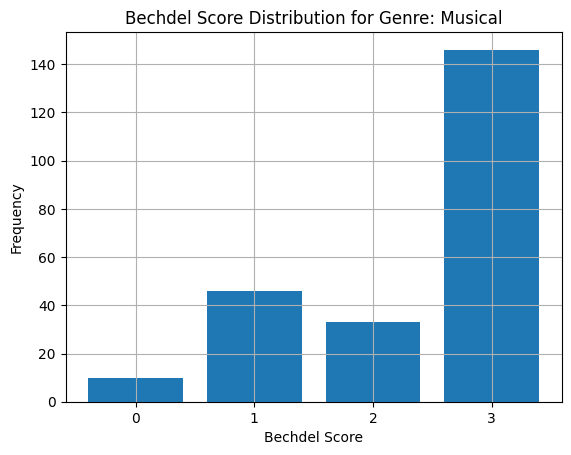

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

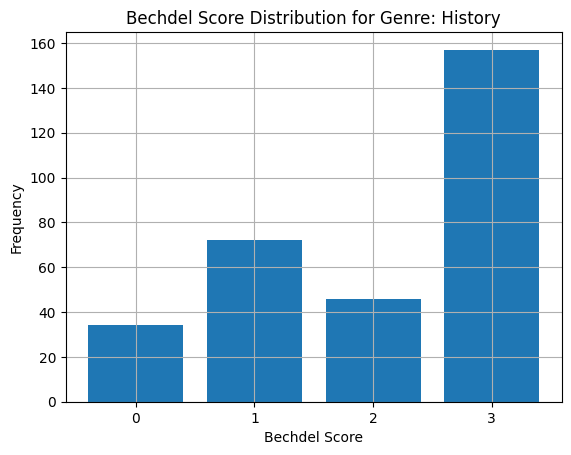

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

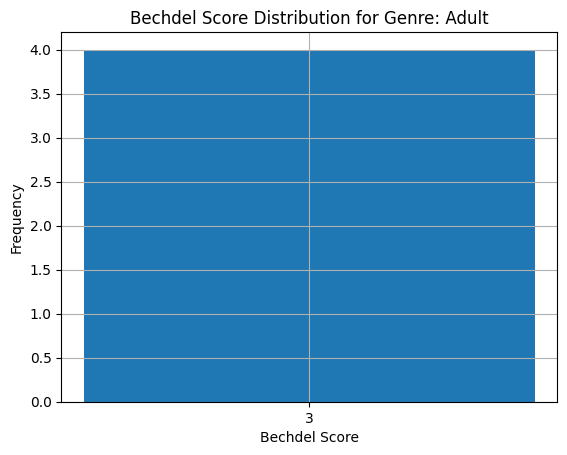

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

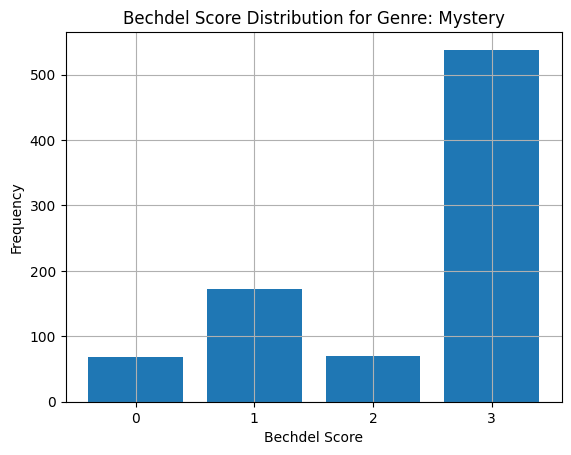

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

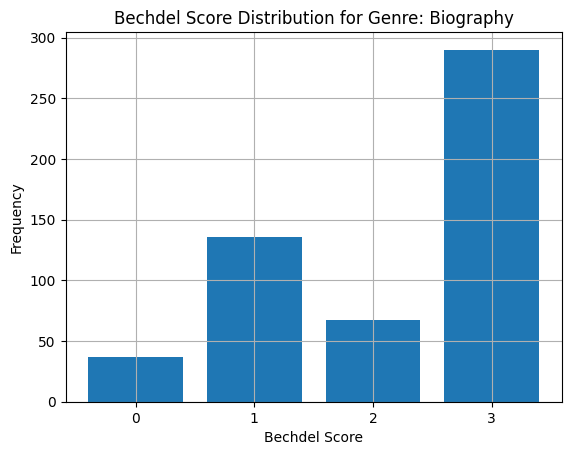

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

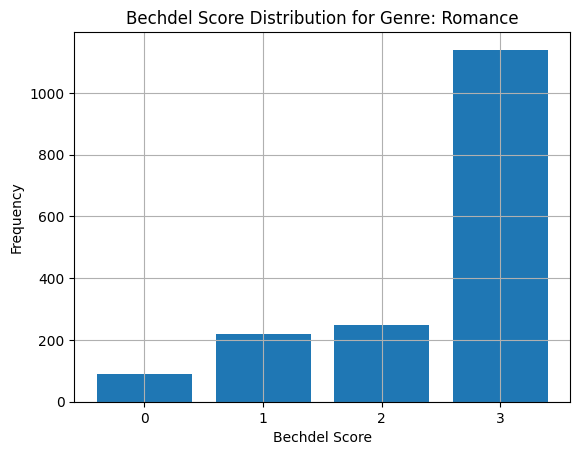

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

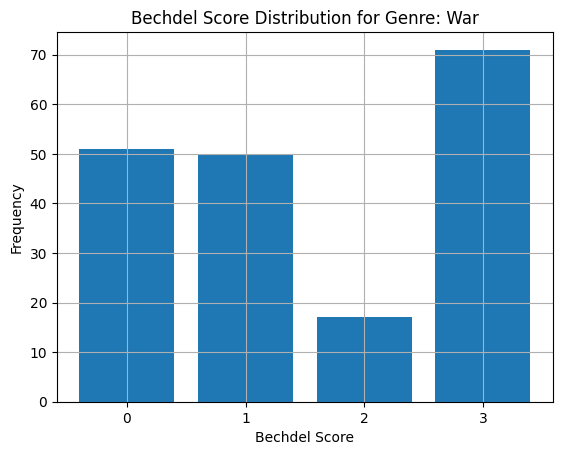

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

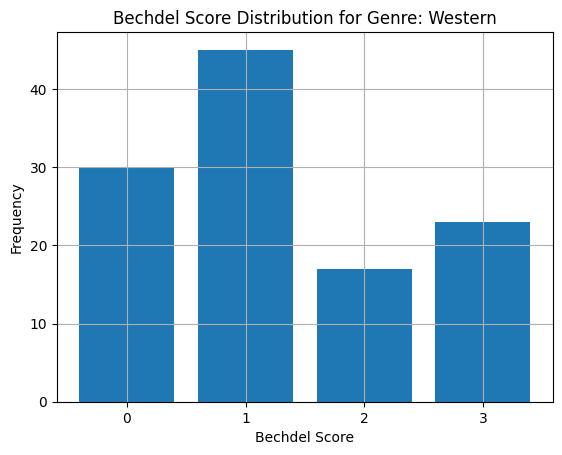

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

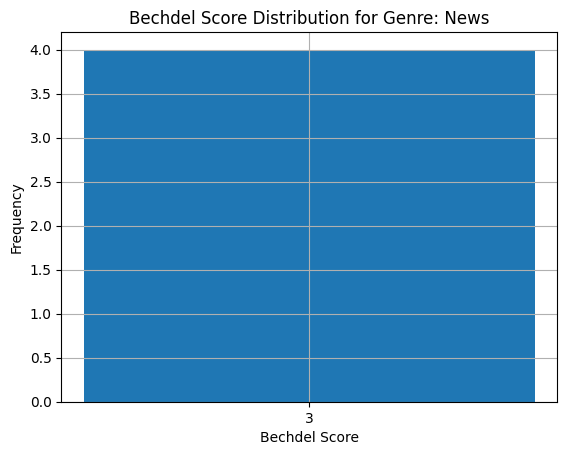

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

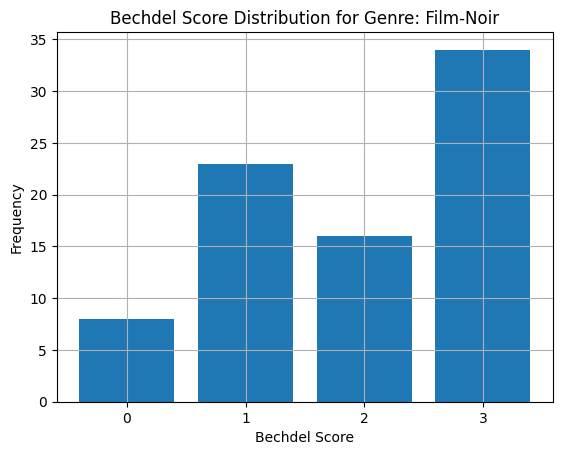

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

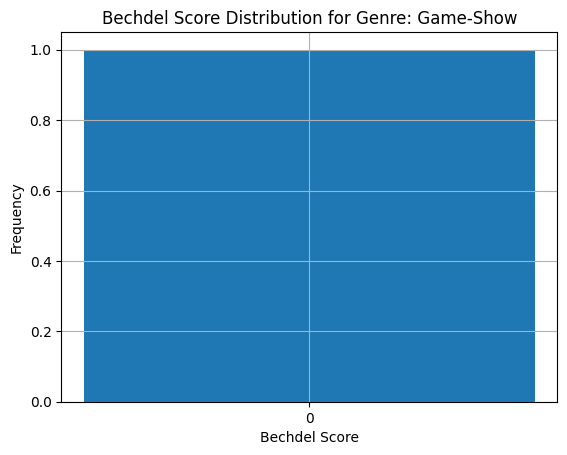

In [46]:
from google.colab import files
for genre in unique_genres:
  if genre != "N/A":
    genre_df = df.filter(df.Genre.contains(genre))
    scores = genre_df.groupBy("Bechdel Score").count().collect()

    scores_dict = {row["Bechdel Score"]: row["count"] for row in scores}
    x = list(scores_dict.keys())
    y = [scores_dict.get(score, 0) for score in x]

    plt.bar(x, y)
    plt.title(f"Bechdel Score Distribution for Genre: {genre}")
    plt.xlabel("Bechdel Score")
    plt.ylabel("Frequency")
    plt.xticks(x)
    plt.grid(True)
    plt.savefig(f"Bechdel Score Distribution for Genre: {genre}.png")
    files.download(f"Bechdel Score Distribution for Genre: {genre}.png")
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

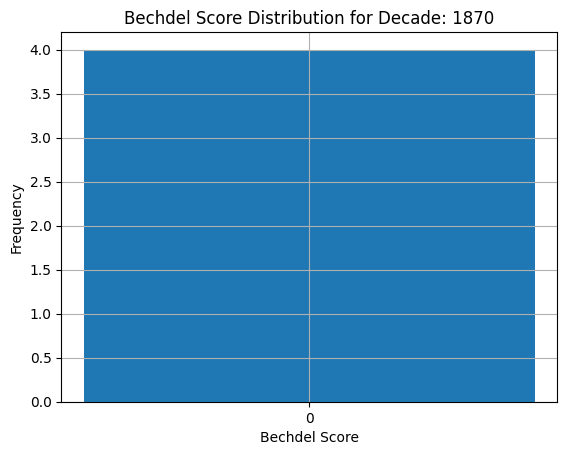

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

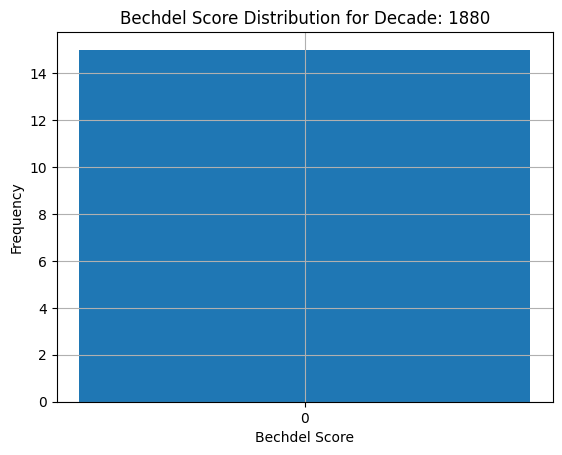

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

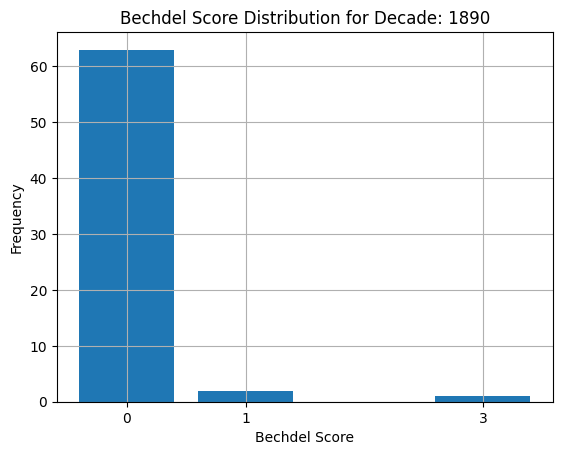

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

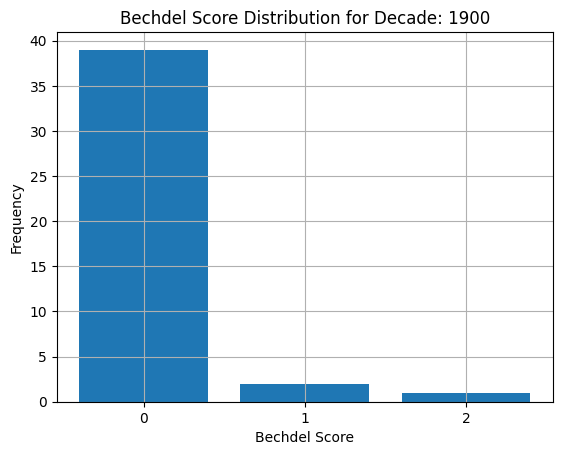

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

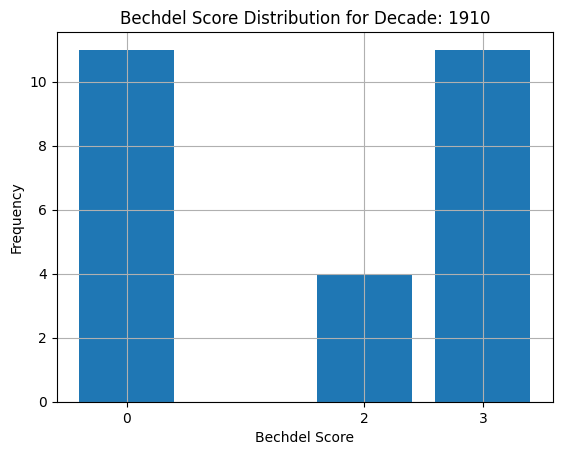

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

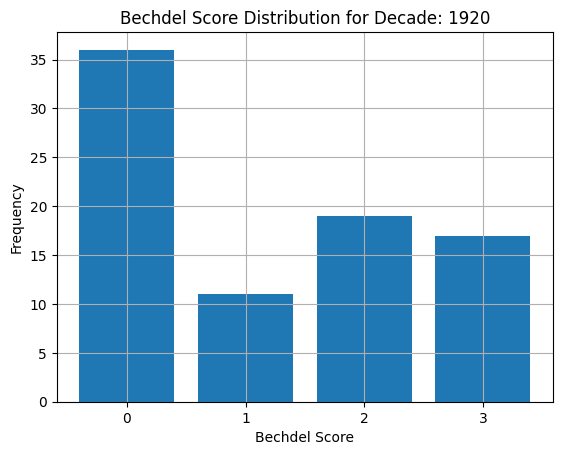

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

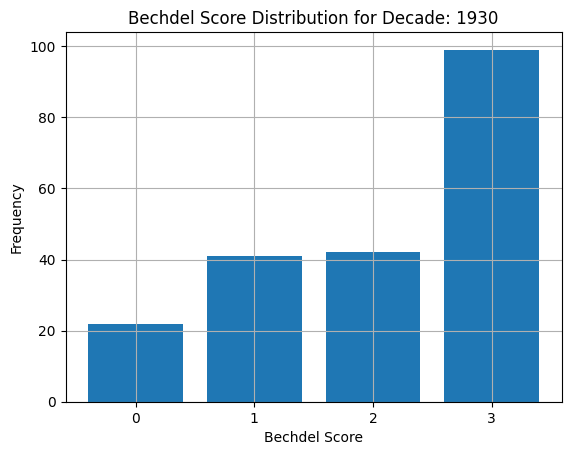

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

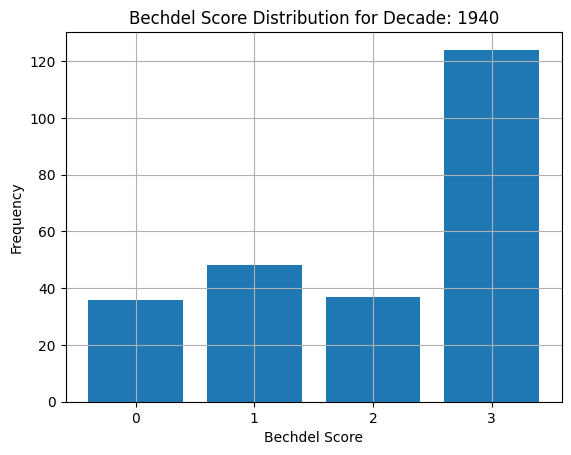

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

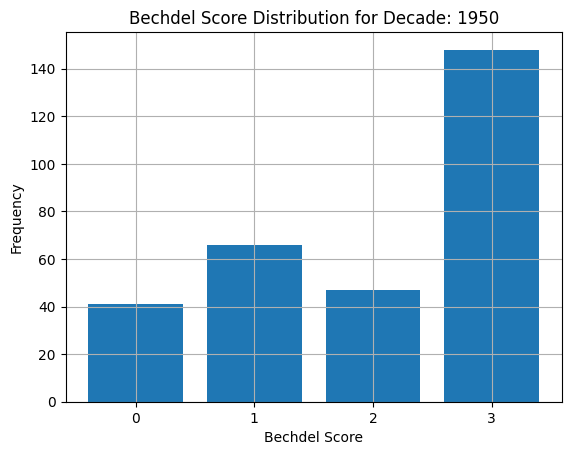

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

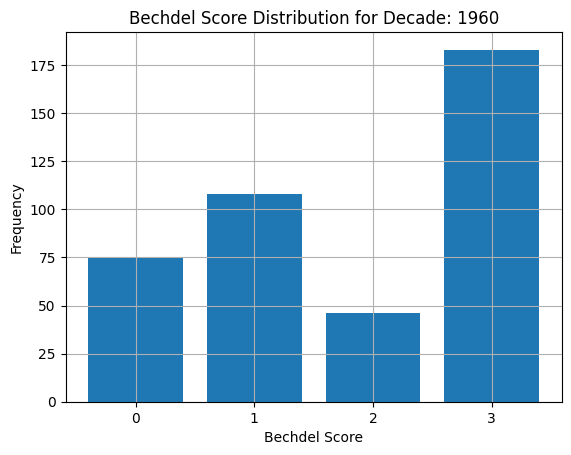

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

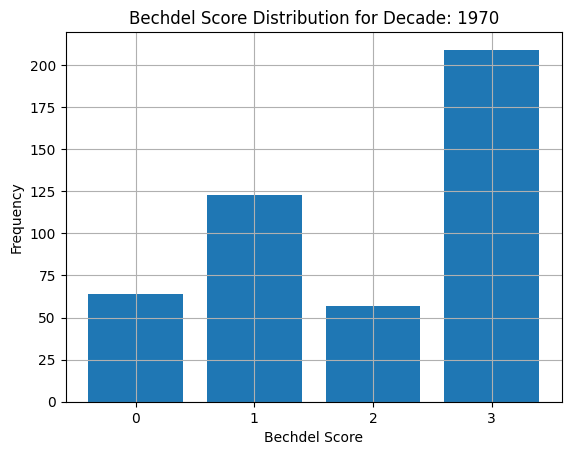

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

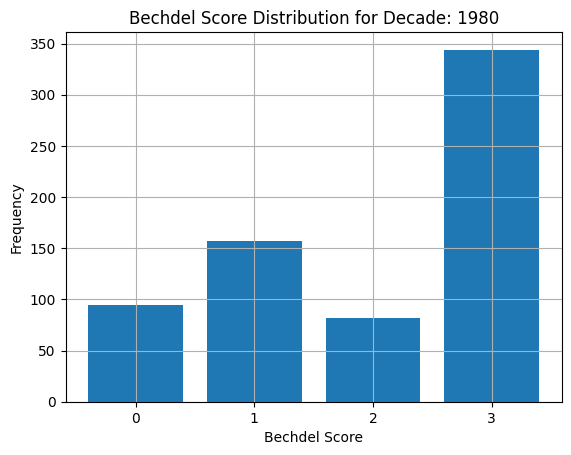

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

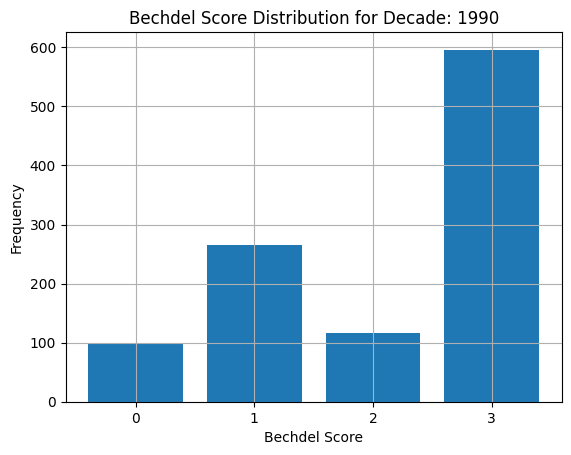

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

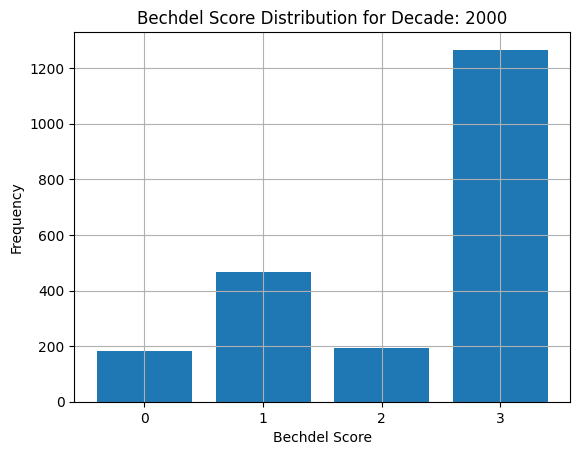

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

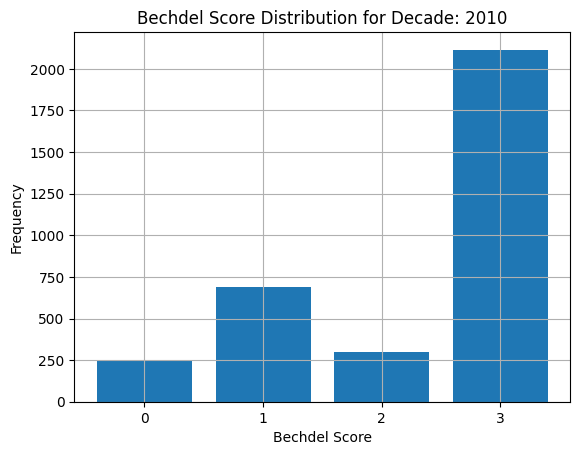

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

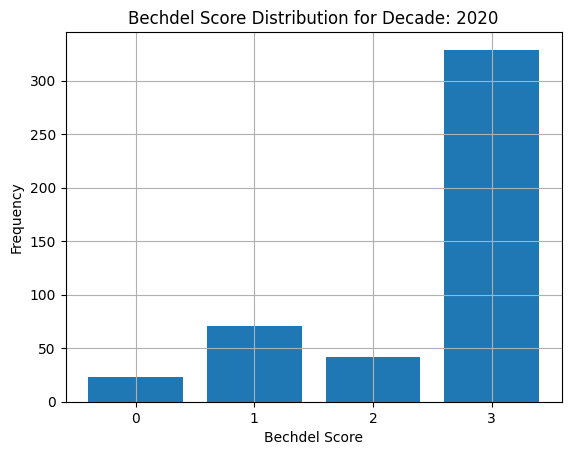

In [36]:

decades = df.select("decade").distinct().orderBy("decade").rdd.flatMap(lambda x: x).collect()

for decade in decades:
    decade_df = df.filter(df.decade == decade)
    scores = decade_df.groupBy("Bechdel Score").count().collect()

    scores_dict = {row["Bechdel Score"]: row["count"] for row in scores}
    x = list(scores_dict.keys())
    y = [scores_dict.get(score, 0) for score in x]

    plt.bar(x, y)
    plt.title(f"Bechdel Score Distribution for Decade: {decade}")
    plt.xlabel("Bechdel Score")
    plt.ylabel("Frequency")
    plt.xticks(x)
    plt.grid(True)
    plt.savefig(f'Score_with_{decade}.png')
    files.download(f'Score_with_{decade}.png')
    plt.show()

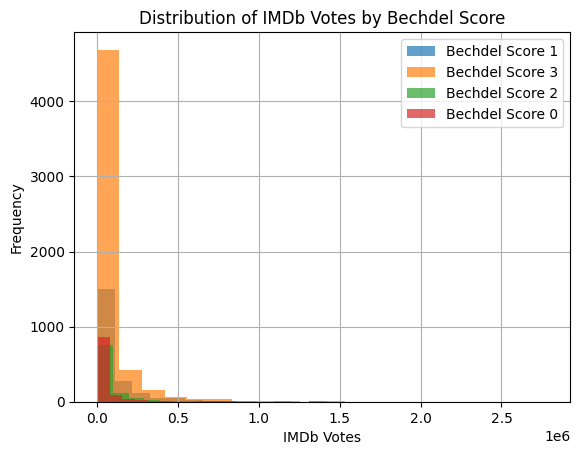

In [51]:
scores = df.groupBy("Bechdel Score").agg({"imdbVotes": "collect_list"}).collect()

for score in scores:
    bechdel_score = score["Bechdel Score"]
    votes_list = score["collect_list(imdbVotes)"]

    plt.hist(votes_list, bins=20, alpha=0.7, label=f"Bechdel Score {bechdel_score}")

plt.xlabel('IMDb Votes')
plt.ylabel('Frequency')
plt.title('Distribution of IMDb Votes by Bechdel Score')
plt.legend()
plt.grid(True)
plt.savefig(f'votes.png')
plt.show()

In [55]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
import gender_guesser.detector as gender

In [58]:
d = gender.Detector()

get_gender_udf = F.udf(lambda name: d.get_gender(u'' + name.split()[0]), StringType())

In [59]:
df_with_gender = df.withColumn("director_gender", get_gender_udf(df["Director"]))

# Group by Bechdel score and director gender
grouped_data = df_with_gender.groupBy("Bechdel Score", "director_gender").count().orderBy("Bechdel Score")

# Create separate histograms for each Bechdel score
bechdel_scores = grouped_data.select("Bechdel Score").distinct().rdd.flatMap(lambda x: x).collect()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

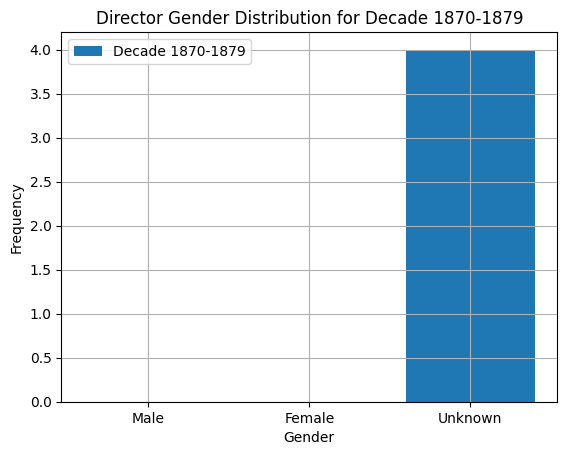

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

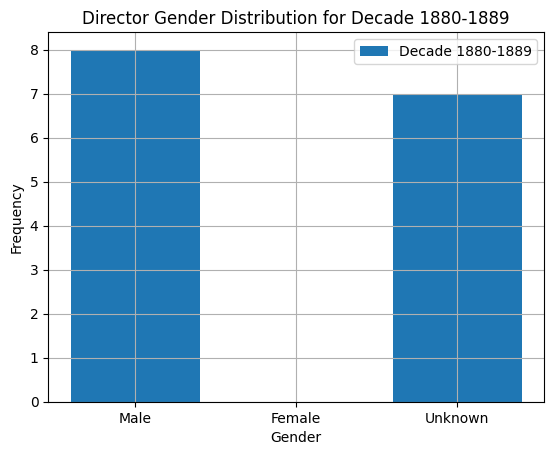

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

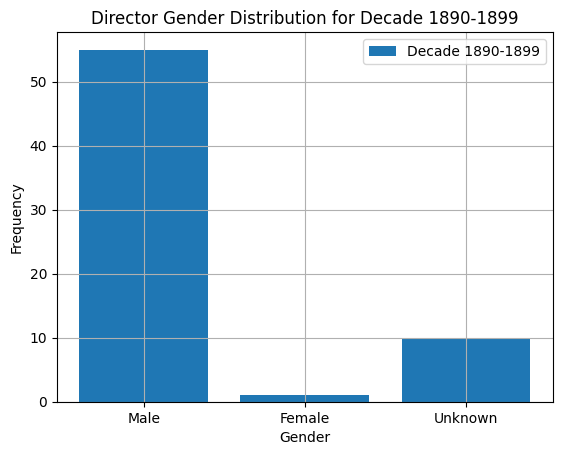

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

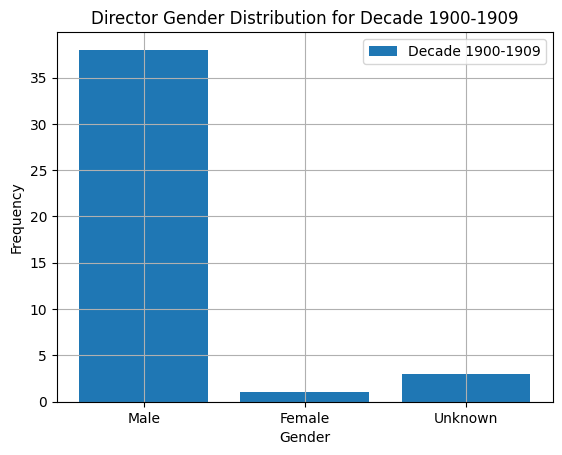

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

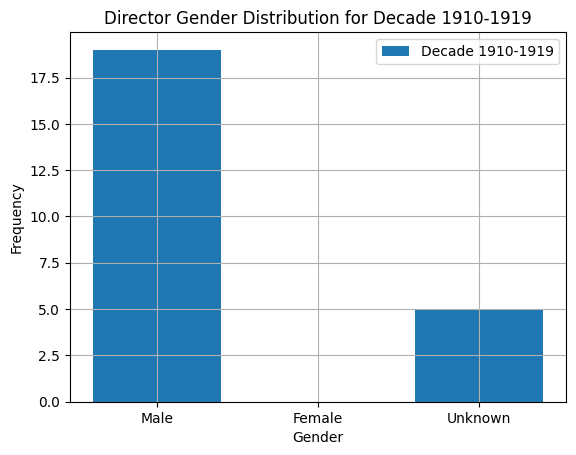

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

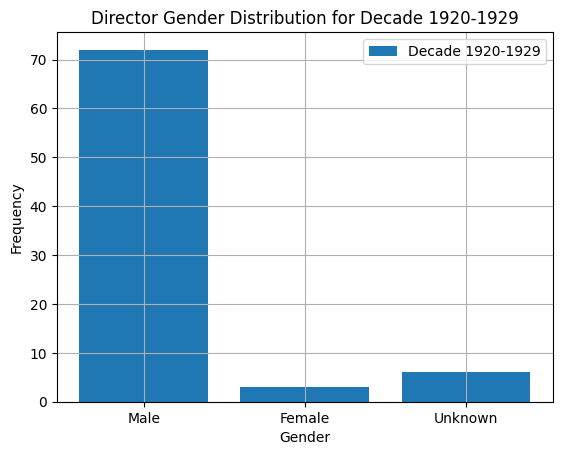

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

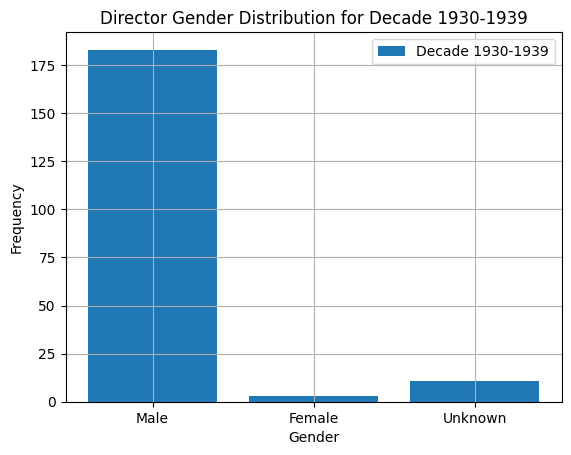

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

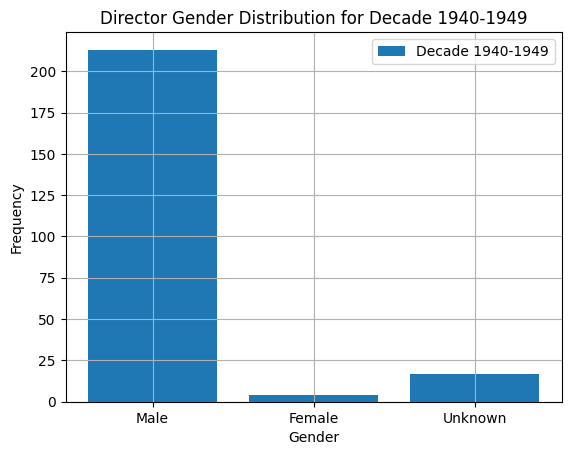

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

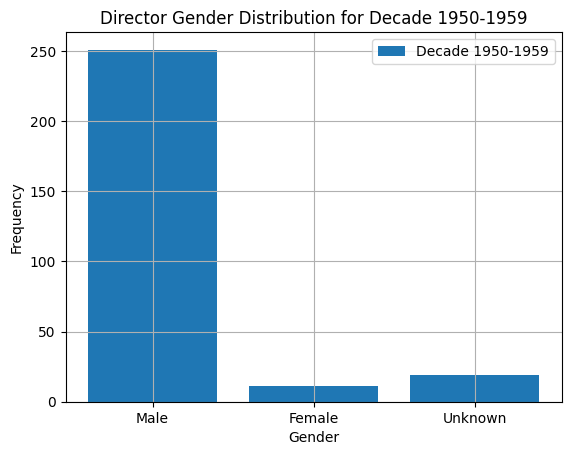

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

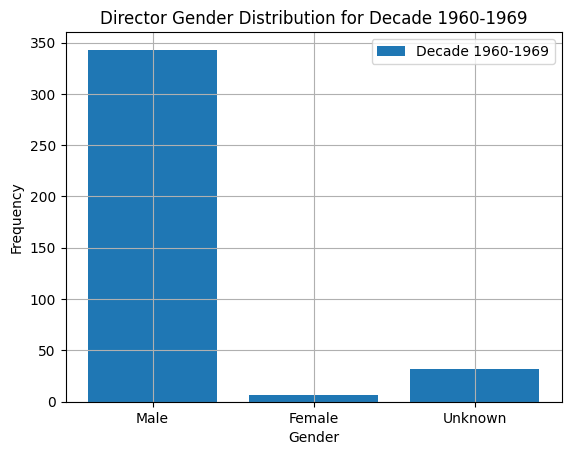

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

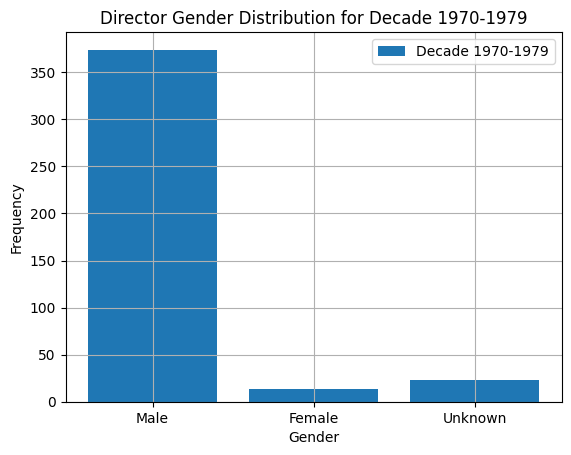

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

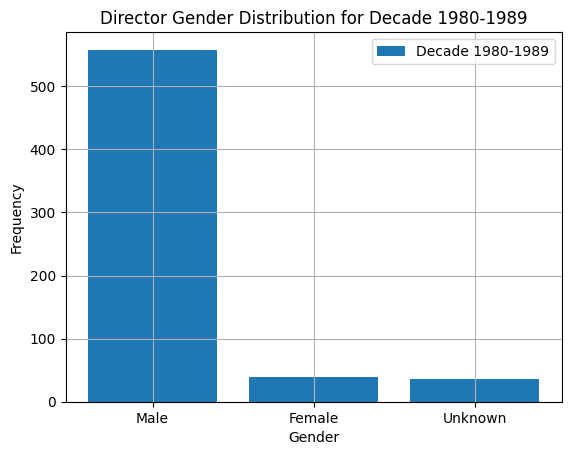

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

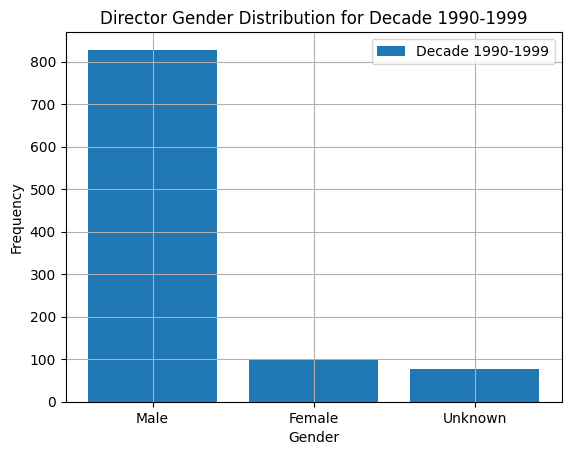

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

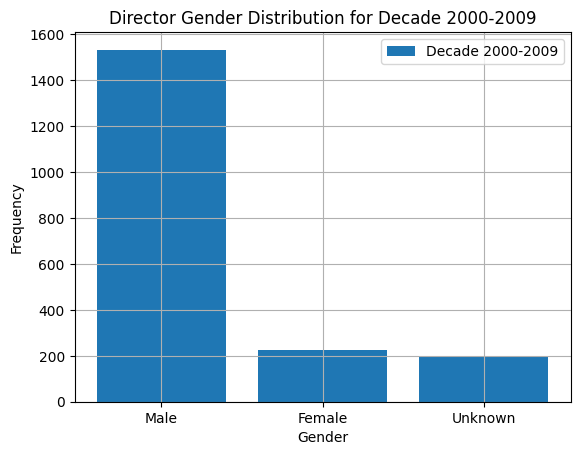

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

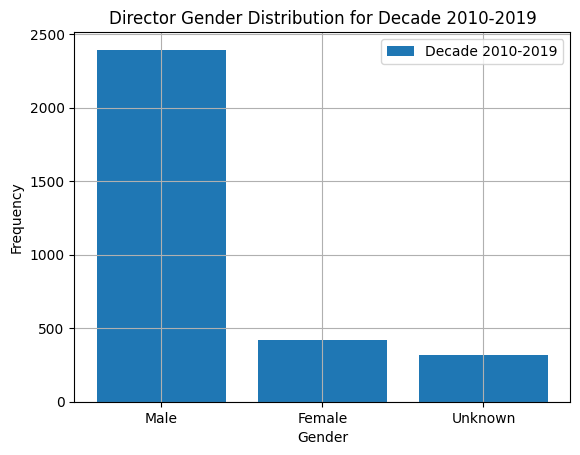

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

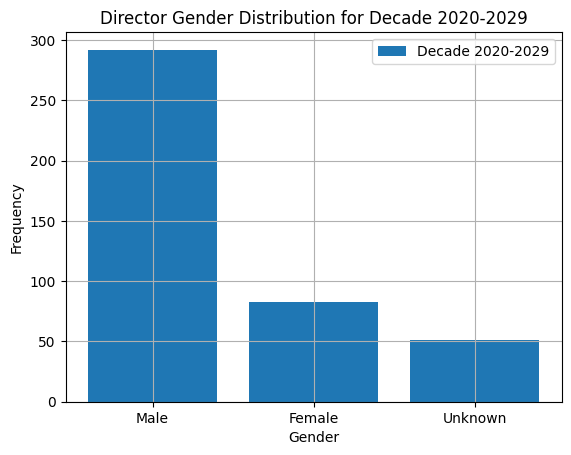

In [65]:
grouped_by_decade_gender = df_with_gender.groupBy("decade", "director_gender").count().orderBy("decade")

# director gender distribution for each decade
for decade in range(1870, 2021, 10):  # Loop through decades from 1870 to 2020
    decade_data = grouped_by_decade_gender.filter((grouped_by_decade_gender["decade"] >= decade) & (grouped_by_decade_gender["decade"] < decade + 10)).collect()
    genders = [row["director_gender"] for row in decade_data]
    counts = [row["count"] for row in decade_data]

    male_counts = [count if gender == "male" else 0 for gender, count in zip(genders, counts)]
    female_counts = [count if gender == "female" else 0 for gender, count in zip(genders, counts)]
    unknown_counts = [count if gender == "unknown" else 0 for gender, count in zip(genders, counts)]

    plt.bar(["Male", "Female", "Unknown"], [sum(male_counts), sum(female_counts), sum(unknown_counts)], label=f"Decade {decade}-{decade + 9}")
    plt.xlabel('Gender')
    plt.ylabel('Frequency')
    plt.title(f'Director Gender Distribution for Decade {decade}-{decade + 9}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'Director Gender Distribution for {decade}-{decade + 9}.png')
    files.download(f'Director Gender Distribution for {decade}-{decade + 9}.png')
    plt.show()
    plt.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

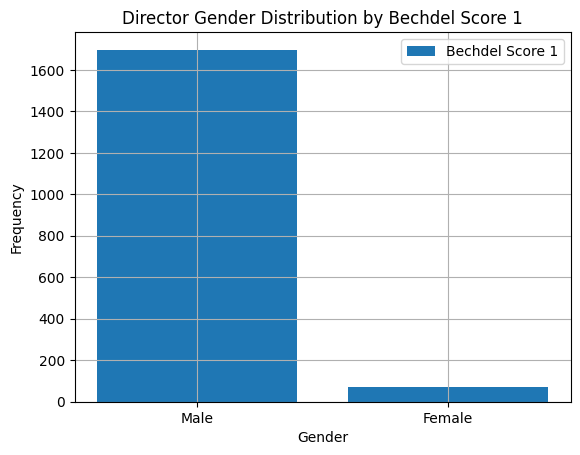

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

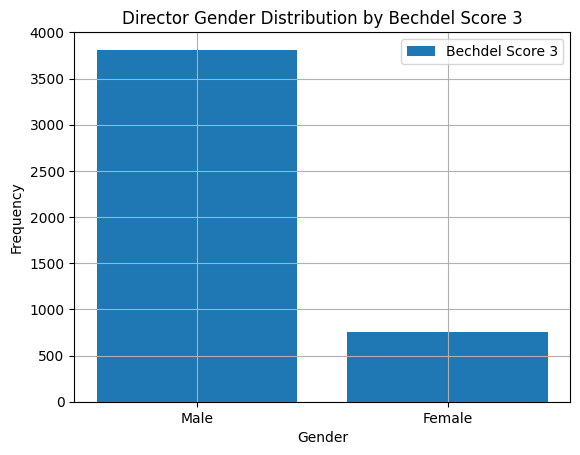

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

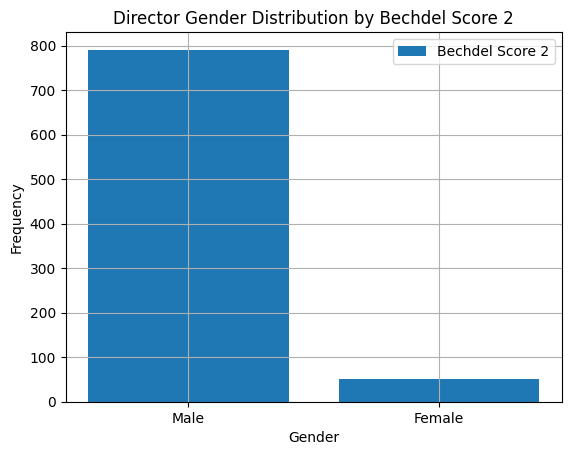

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

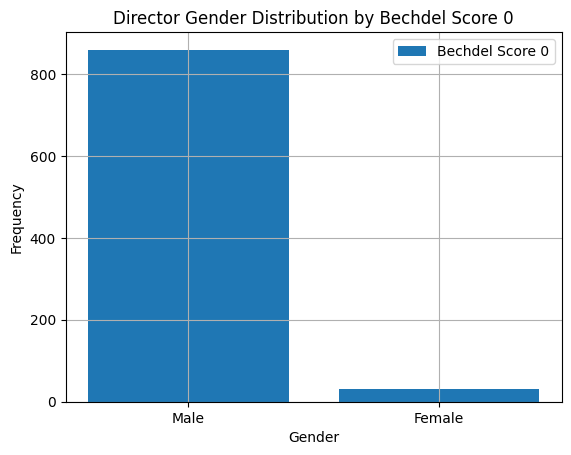

In [61]:
for score in bechdel_scores:
    score_data = grouped_data.filter(grouped_data["Bechdel Score"] == score).collect()
    genders = [row["director_gender"] for row in score_data]
    counts = [row["count"] for row in score_data]

    male_counts = [count if gender == "male" else 0 for gender, count in zip(genders, counts)]
    female_counts = [count if gender == "female" else 0 for gender, count in zip(genders, counts)]

    plt.bar(["Male", "Female"], [sum(male_counts), sum(female_counts)], label=f"Bechdel Score {score}")
    plt.xlabel('Gender')
    plt.ylabel('Frequency')
    plt.title(f'Director Gender Distribution by Bechdel Score {score}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'Director Gender Distribution by Bechdel Score {score}.png')
    files.download(f'Director Gender Distribution by Bechdel Score {score}.png')
    plt.show()

In [67]:
df_with_gender = df.withColumn("writer_gender", get_gender_udf(df["Writer"]))

# Group by Bechdel score and director gender
grouped_data = df_with_gender.groupBy("Bechdel Score", "writer_gender").count().orderBy("Bechdel Score")

# Create separate histograms for each Bechdel score
bechdel_scores = grouped_data.select("Bechdel Score").distinct().rdd.flatMap(lambda x: x).collect()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

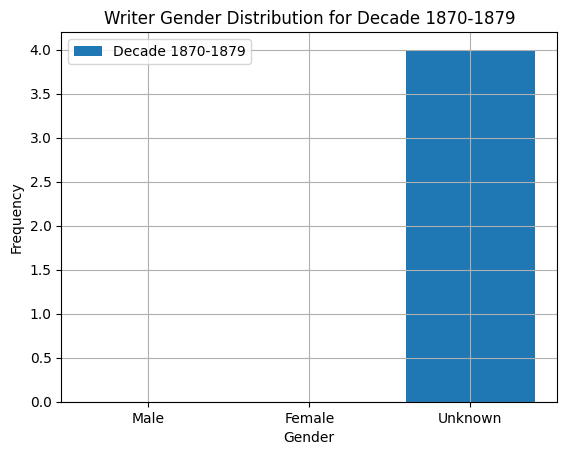

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

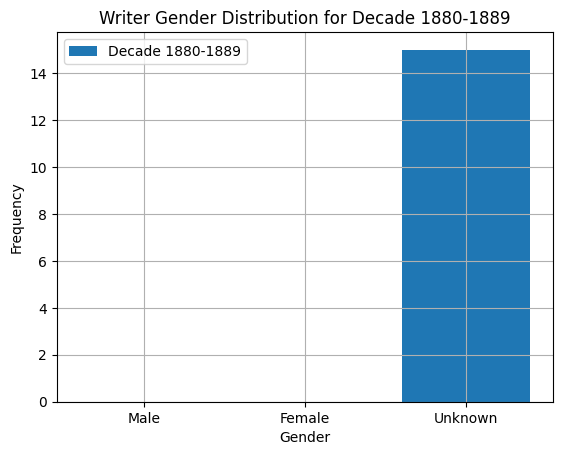

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

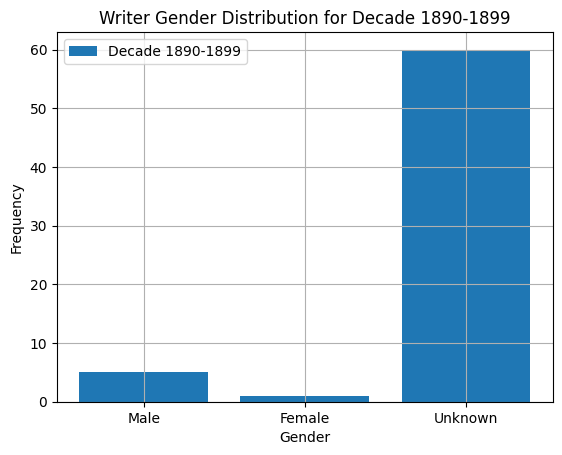

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

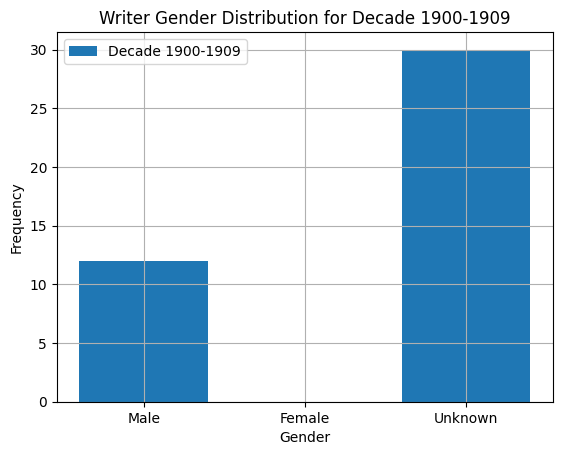

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

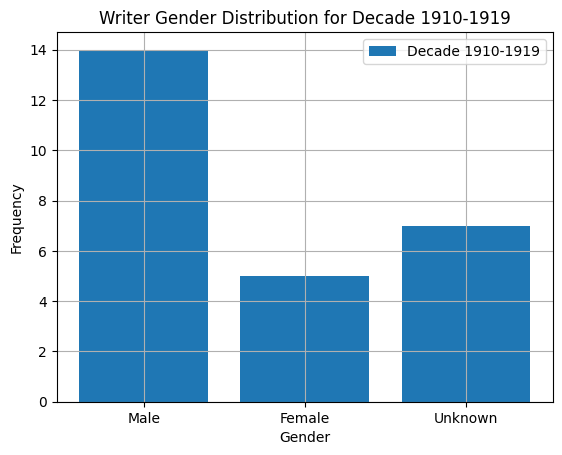

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

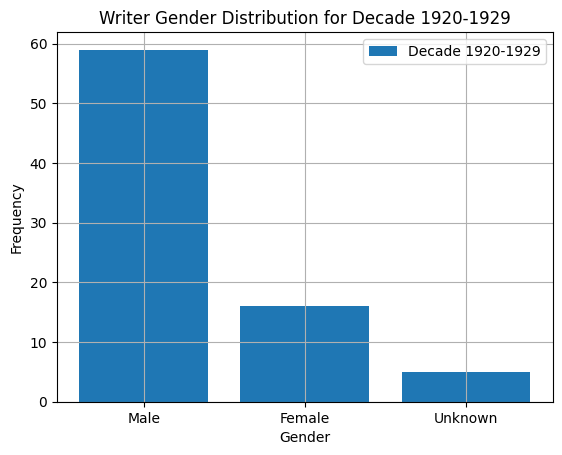

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

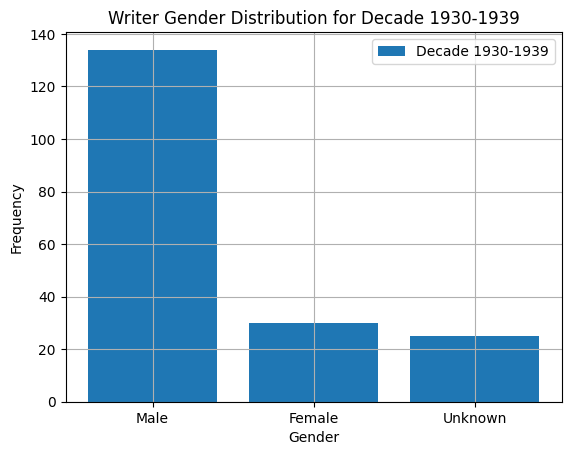

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

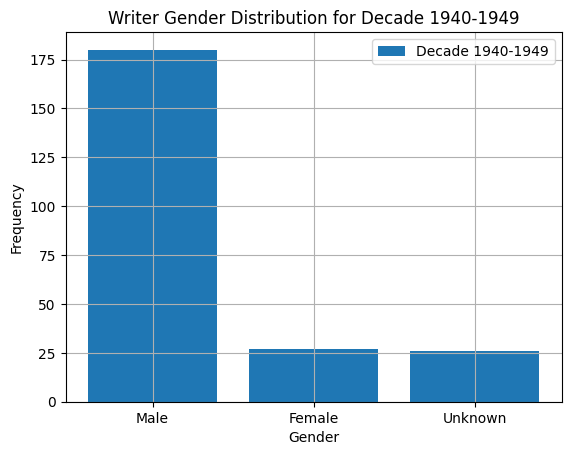

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

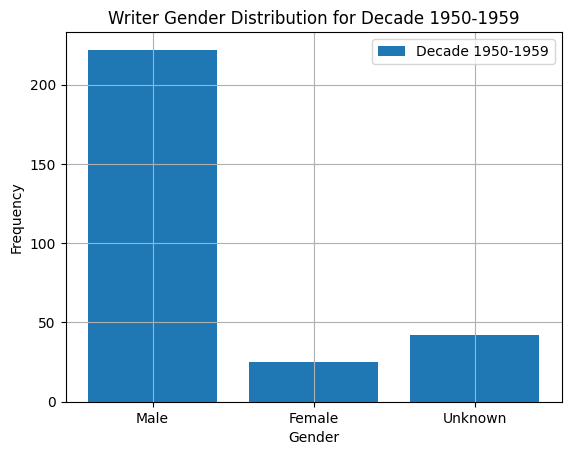

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

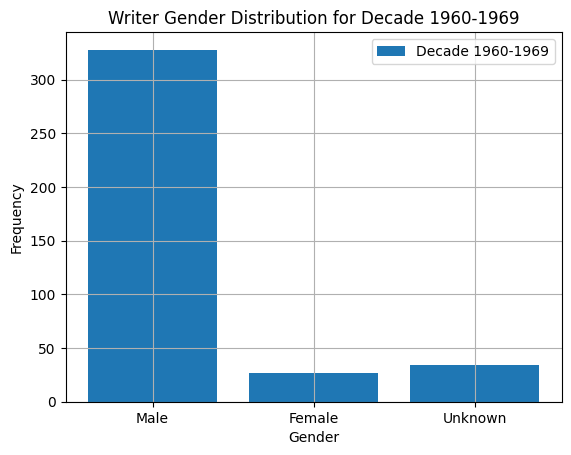

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

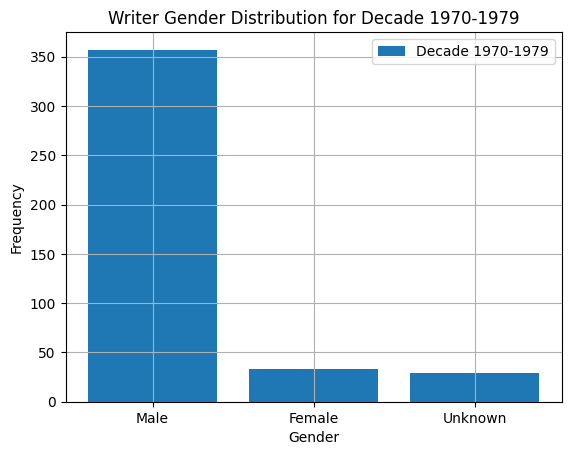

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

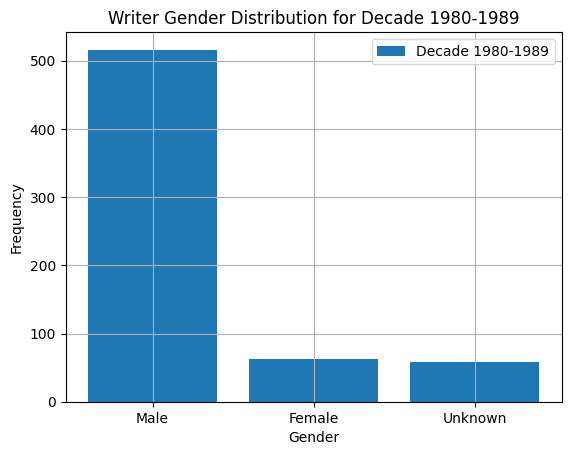

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

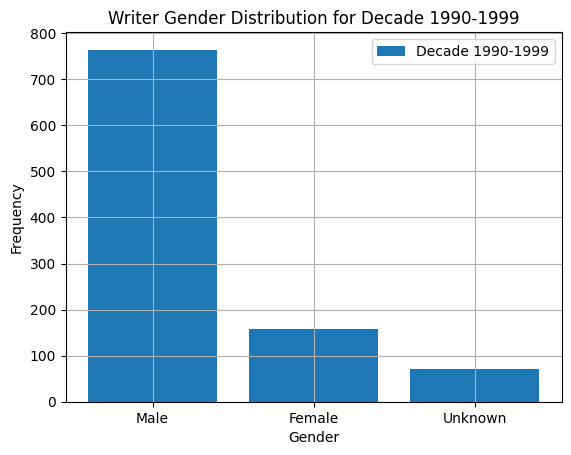

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

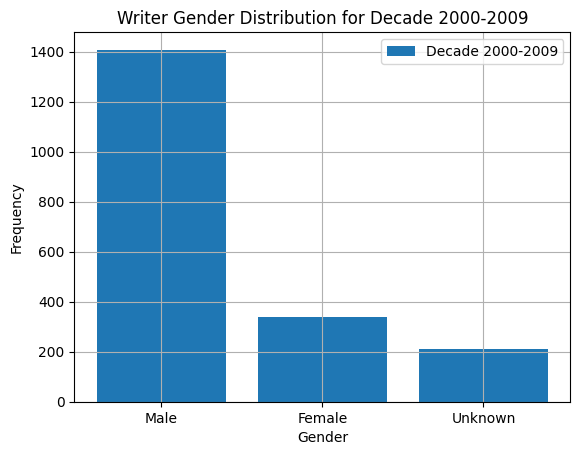

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

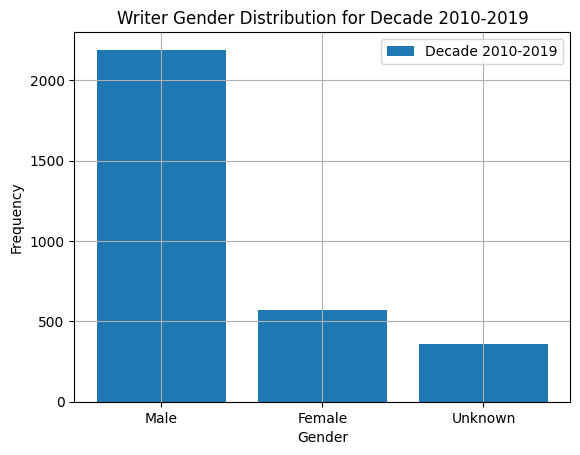

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

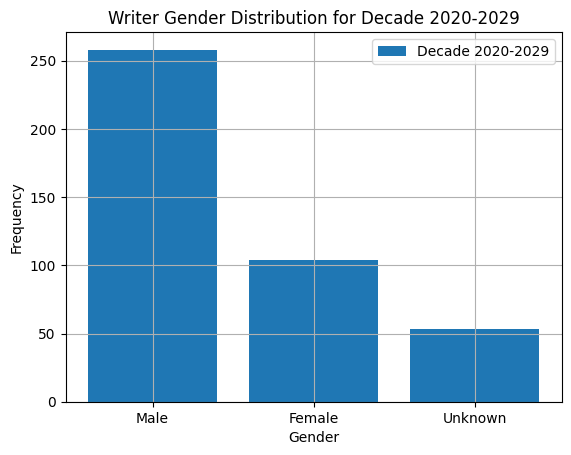

In [68]:
grouped_by_decade_gender = df_with_gender.groupBy("decade", "writer_gender").count().orderBy("decade")

# writer gender distribution for each decade
for decade in range(1870, 2021, 10):  # Loop through decades from 1870 to 2020
    decade_data = grouped_by_decade_gender.filter((grouped_by_decade_gender["decade"] >= decade) & (grouped_by_decade_gender["decade"] < decade + 10)).collect()
    genders = [row["writer_gender"] for row in decade_data]
    counts = [row["count"] for row in decade_data]

    male_counts = [count if gender == "male" else 0 for gender, count in zip(genders, counts)]
    female_counts = [count if gender == "female" else 0 for gender, count in zip(genders, counts)]
    unknown_counts = [count if gender == "unknown" else 0 for gender, count in zip(genders, counts)]

    plt.bar(["Male", "Female", "Unknown"], [sum(male_counts), sum(female_counts), sum(unknown_counts)], label=f"Decade {decade}-{decade + 9}")
    plt.xlabel('Gender')
    plt.ylabel('Frequency')
    plt.title(f'Writer Gender Distribution for Decade {decade}-{decade + 9}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'Writer Gender Distribution for {decade}-{decade + 9}.png')
    files.download(f'Writer Gender Distribution for {decade}-{decade + 9}.png')
    plt.show()
    plt.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

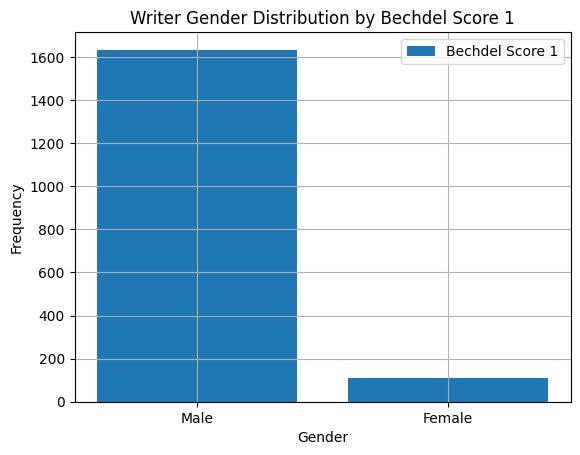

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

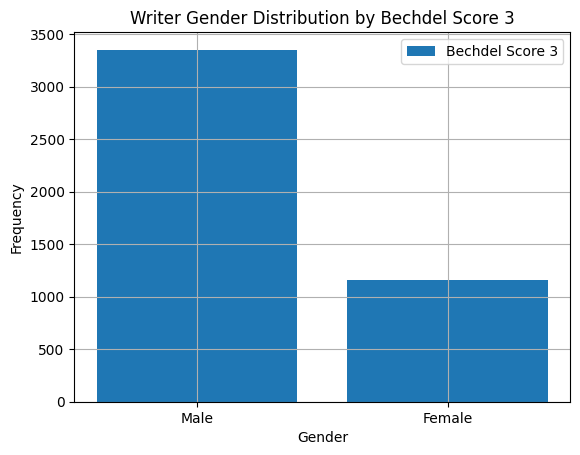

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

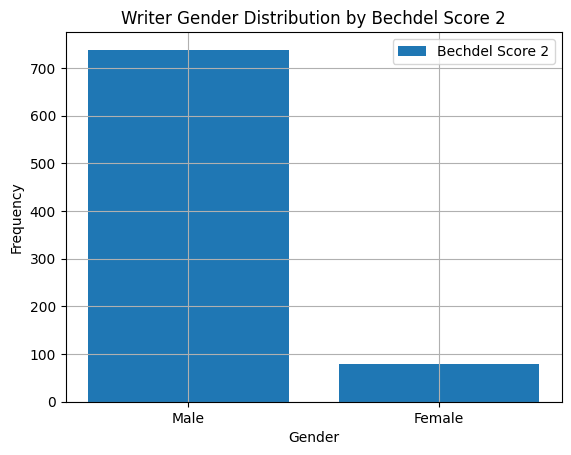

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

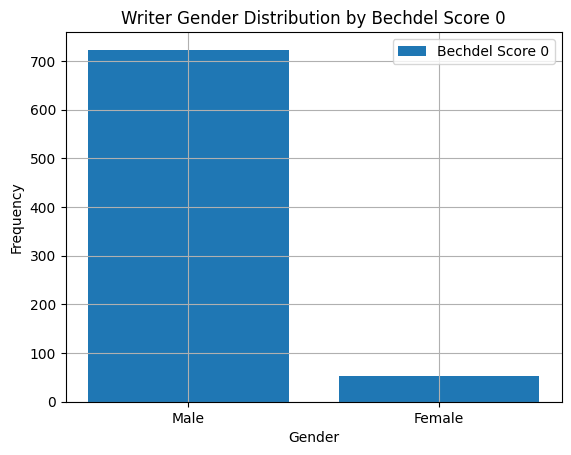

In [69]:
for score in bechdel_scores:
    score_data = grouped_data.filter(grouped_data["Bechdel Score"] == score).collect()
    genders = [row["writer_gender"] for row in score_data]
    counts = [row["count"] for row in score_data]

    male_counts = [count if gender == "male" else 0 for gender, count in zip(genders, counts)]
    female_counts = [count if gender == "female" else 0 for gender, count in zip(genders, counts)]

    plt.bar(["Male", "Female"], [sum(male_counts), sum(female_counts)], label=f"Bechdel Score {score}")
    plt.xlabel('Gender')
    plt.ylabel('Frequency')
    plt.title(f'Writer Gender Distribution by Bechdel Score {score}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'Writer Gender Distribution by Bechdel Score {score}.png')
    files.download(f'Writer Gender Distribution by Bechdel Score {score}.png')
    plt.show()